---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

### Saverio Monaco
##### MAT: 2012264

# Homework 3 - Deep Reinforcement Learning
---
---

In [35]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np
from collections import deque # fixed size FIFO list

# Deep Learning Stuff
import torch
from torch import nn
import gym

# Visualizing
import matplotlib.pyplot as plt
from gym.wrappers import Monitor
from IPython.display import HTML
from IPython import display as ipythondisplay
import base64

# Other
import random
from tqdm.notebook import tqdm
import io
import os
import glob

# Automatic tuning tool
import optuna

# Second set
import flappy_bird_gym
import time
from scipy import ndimage # rotate image for display
from IPython.display import clear_output

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


In [3]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cuda


In [41]:
#################
#### CLASSES ####
#################

class ReplayMemory(object):
    '''
    To perform experience replay.
    We will draw uniformly at random from the pool of stored sample to learn.
    Thi avoids (temporal) correlation between consecutive learning instances.
    '''
    def __init__(self, capacity):
        ''' Initialize a deque with maximum capacity maxlen. '''
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        ''' Add a new sample to the deque, removes the oldest one if it is already full. '''
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append( (state, action, next_state, reward) )
        
    def sample(self, batch_size):
        ''' Randomly select "batch_size" samples '''
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size)

    def __len__(self):
        ''' Return the number of samples currently stored in the memory '''
        return len(self.memory)

class DQN(nn.Module):
    ''' 
    Network for policy network and target network 
    state_space_dim:  (INPUT)  dimension of state space (e.g pixels in a image)
    action_space_dim: (OUTPUT) dimension of action space (e.g go left, go right)
    '''
    def __init__(self, DQN_state_space_dim, DQN_action_space_dim):
        super().__init__()
            
        self.sdim = DQN_state_space_dim
        self.adim = DQN_action_space_dim
            
        self.linear = nn.Sequential(
            nn.Linear(self.sdim, 128),
            nn.Tanh(),
            nn.Linear(128,128),
            nn.Tanh(),
            nn.Linear(128,self.adim)
                )

    def forward(self, x):
        return self.linear(x)
    
#
#          |---------> [Prediction Network (DQN)]--------
#          |                |                            \
# [INPUT]--|                | Parameter update            \___Loss
#          |               \/                            /
#          |---------> [Target Network (DQN)]------------
#
class FullQNets(nn.Module):
    ''' 
    Handles all the networks, environments, and others
    '''
    def __init__(self, envname):
        super().__init__()
        
        self.envname = envname
        
        tempenv = gym.make(self.envname) 
            
        self.state_space_dim = tempenv.observation_space.shape[0]
        
        if self.envname == 'BipedalWalkerHardcore-v3':
            self.action_space_dim = 4 # Box attribute in BipedalWalker are different
        else:
            self.action_space_dim = tempenv.action_space.n
        
        self.policy_net = DQN(self.state_space_dim, self.action_space_dim)
        self.target_net = DQN(self.state_space_dim, self.action_space_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def choose_action_epsilon_greedy(self, state, epsilon):
        self.policy_net.eval()
        if epsilon > 1 or epsilon < 0:
            raise Exception('The epsilon value must be between 0 and 1')
                
        # Evaluate the network output from the current state
        with torch.no_grad():
            self.policy_net.eval()
            state = torch.tensor(state, dtype=torch.float32, device=device) # Convert the state to tensor
            net_out = self.policy_net(state)

        # Get the best action (argmax of the network output)
        best_action = int(net_out.argmax())
        # Get the number of possible actions
        action_space_dim = net_out.shape[-1]

        # Select a non optimal action with probability epsilon, otherwise choose the best action
        if random.random() < epsilon:
            # List of non-optimal actions
            non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
            # Select randomly
            action = random.choice(non_optimal_actions)
        else:
            # Select best action
            action = best_action
        
        return action, net_out.cpu().numpy()
    
    def choose_action_softmax(self, state, temperature):
        self.policy_net.to(device)
        if temperature < 0:
            raise Exception('The temperature value must be greater than or equal to 0 ')
        
        # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
        if temperature == 0:
            return self.choose_action_epsilon_greedy(state, 0)
    
        # Evaluate the network output from the current state
        with torch.no_grad():
            self.policy_net.eval()
            state = torch.tensor(state, dtype=torch.float32, device=device)
            net_out = self.policy_net(state)

        # Apply softmax with temp
        temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
        softmax_out = nn.functional.softmax(net_out / temperature, dim=0).cpu().numpy()
                
        # Sample the action using softmax output as mass pdf
        all_possible_actions = np.arange(0, softmax_out.shape[-1])
        action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
        return action, net_out.cpu().numpy()
    
    def update_step(self, replay_mem, gamma, optimizer, loss_fn, batch_size):        
        self.policy_net.to(device)
        self.target_net.to(device)
        # Sample the data from the replay memory
        batch = replay_mem.sample(batch_size)
        batch_size = len(batch)

        # Create tensors for each element of the batch
        states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
        actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
        rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

        # Compute a mask of non-final states (all the elements where the next state is not None)
        non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
        non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool, device=device)

        # Compute all the Q values (forward pass)
        self.policy_net.train()
        q_values = self.policy_net(states)
        # Select the proper Q value for the corresponding action taken Q(s_t, a)
        state_action_values = q_values.gather(1, actions.unsqueeze(1))
        
        # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
        with torch.no_grad():
            self.target_net.eval()
            q_values_target = self.target_net(non_final_next_states)
        next_state_max_q_values = torch.zeros(batch_size, device=device)
        next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

        # Compute the expected Q values
        expected_state_action_values = rewards + (next_state_max_q_values * gamma)
        expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

        # Compute the Huber loss
        loss = loss_fn(state_action_values, expected_state_action_values)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 2)
        optimizer.step()
        
        return optimizer
    
    def play_a_game(self, show = True, debug = False):
        # Initialize the Gym environment
        env = gym.make(self.envname) 
        
        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        # Go on until the pole falls off or the score reach 490
        while not done:
            # Choose the best action (temperature 0)
            action, q_values = self.choose_action_softmax(state, temperature=0)
            if debug:
                print('action', action)
                print('state', state)
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            # Visually render the environment
            if show:
                env.render()
            # Update the final score (+1 for each step)
            score += reward 
            # Set the current state for the next iteration
            state = next_state
            # Check if the episode ended (the pole fell down)
        # Print the final score
        if show:
            print(f"SCORE: {score}") 
        env.close()
        
        return score
    
    def training_loop(self, max_epoch, loss_fn, optimizer_fn, initial_value=5, gamma = 0.97, 
                 replay_memory_capacity = 10000, lr = 1e-2, reg_opt = 1e-5, 
                 target_net_update_steps = 10, bad_state_penalty = 0, test_policy = False,
                 batch_size = 128, min_samples_for_training = 1000, render=False, optunaprint = False, maxplayers = 0,
                 optuna_epoch_limit = False):
        '''
        PARAMETERS
        gamma: gamma parameter for the long term reward
        replay_memory_capacity: Replay memory capacity
        lr: Optimizer learning rate
        loss_fn: Loss function
        optimizer_fn: Optimizer function
        target_net_update_steps: Number of episodes to wait before updating the target network
        batch_size: Number of samples to take from the replay memory for each update
        bad_state_penalty: Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
        min_samples_for_training: Minimum samples in the replay memory to enable the training
        test_policy: if True, for every target_net_update_steps steps, it will play 10 games following its policy (T=0)
                     and if it obtains the maximum score (500) it will exit
                     if is int > 0 it will do the same playing test_policy number of games
        '''
        env = gym.make(self.envname)
        optimizer = optimizer_fn(self.policy_net.parameters(), lr=lr, weight_decay=reg_opt)
        has_learned = False # Boolean variable, if test_policy == True and has obtained the max score on the test games
                            # it will exit learning
        # We compute the exponential decay in such a way the shape of the exploration 
        # profile does not depend on the number of iterations
        exp_decay = np.exp(-np.log(initial_value) / max_epoch * 6) 
        exploration_profile = [initial_value * (exp_decay ** i) for i in range(max_epoch)]
        
        ### Initialize the replay memory
        replay_mem = ReplayMemory(replay_memory_capacity)   
        
        env.seed(0)
        policy_num = 0
        progress = tqdm(exploration_profile)
        #print('n iterations:', len(exploration_profile) )
        for episode_num, tau in enumerate(progress):
            # Reset the environment and get the initial state
            state = env.reset()
            
            # Reset the score. The final score will be the total amount of steps before the pole falls
            score = 0
            
            done = False
            
            # Go on until the pole falls off
            while not done:
                # Choose the action following the policy
                action, q_values = self.choose_action_softmax(state, temperature=tau)
                
                # Apply the action and get the next state, the reward and a flag "done" 
                # that is True if the game is ended
                next_state, reward, done, info = env.step(action)
                
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 1
                reward = reward - pos_weight * np.abs(state[0])
                
                # Update the final score (+1 for each step)
                score += 1
                
                # Update the replay memory
                replay_mem.push(state, action, next_state, reward)

                # Update the network
                if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                    optimizer = self.update_step(replay_mem, gamma, optimizer, loss_fn, batch_size)
                
                if render:
                    # Visually render the environment (disable to speed up the training)
                    env.render()

                # Set the current state for the next iteration
                state = next_state

            # Update the target network every target_net_update_steps episodes
            if episode_num % target_net_update_steps == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict()) # This will copy the weights of the policy network to the target network
                
                # If test_policy is True, we check every target_net_update_setps if the net has learned.+
                # the net has learnet if it can obtain the maximum score 10 times in a row following its policy (with T=0)
                # or test_policy times in a row if is int
                if test_policy:
                    policy_num = policy_num + 1
                    if type(test_policy)==int:
                        ngames = test_policy
                    else:
                        ngames = 10
                        
                    test_score = 0
                    for game in range(ngames):
                        test_score = test_score + self.play_a_game(show=False)
                    test_score = test_score/ngames
                    if not type(optunaprint)==int:
                        print('Policy {:d} | Mean SCORE: {:.2f} '.format(policy_num,test_score) )
                    if test_score >= 500:
                        has_learned = True
            # Print the final score
            if optunaprint:
                progress.set_description("{:d}/{:d} :: SCORE: {:d} - T: {:.4f}".format(optunaprint,maxplayers, score,tau))
            else:
                progress.set_description("SCORE: {:d} - T: {:.4f}".format(score,tau))
            
            if has_learned == True:
                if not optunaprint:
                    print('Learning completed at epoch: {:d}'.format(episode_num))
                env.close()
                return episode_num
            
            # For speeding up the training for the optuna gridsearch, we might want to kill the learning 
            # of models that are taking longer than the best one
            if type(optuna_epoch_limit) == int:
                if episode_num >= optuna_epoch_limit:
                    env.close()
                    return episode_num

        env.close()
        return max_epoch

## CartPole-v1

In [5]:
def optuna_qlearning(ntrials = 200, nepochs = 1000):
    ''' Function for Optuna hyperparameter tuning '''
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='minimize')
    
    optimizers = [torch.optim.Adam, torch.optim.SGD]
    global player
    player = 1
    global epochs
    epochs = nepochs
    def callback(study, trial):
        ''' Callback function, saves the best model. '''
        global best_model
        # If the best model result is the current one...
        if study.best_trial == trial:
            # Saves the best model to best_model
            best_model = optmodel
    
    def optuna_train(trial):
        ''' Main function for optuna. '''
        cfg = {
          'reg': trial.suggest_loguniform('reg',1e-5, 1e-3),
          'lr' : trial.suggest_loguniform('lr', 1e-4, 1e-3),
          'optimizer': trial.suggest_categorical('optimizer',list(range(len(optimizers)))),
          'gamma' : trial.suggest_uniform('gamma', .95, 1),
          #'penality' : trial.suggest_categorical('penality', [0]),
          'init_v' : trial.suggest_loguniform('init_v', 1,10)
        }
        
        global player
        global optmodel
        global epochs
        optmodel =  FullQNets('CartPole-v1')
        optmodel.to(device)
        
        learning_epochs = optmodel.training_loop(nepochs, nn.SmoothL1Loss(), optimizers[cfg['optimizer']], lr=cfg['lr'], test_policy=10,
                                                 reg_opt = cfg['reg'], gamma=cfg['gamma'], initial_value=cfg['init_v'],
                                                 bad_state_penalty = 0, optunaprint=player, maxplayers = ntrials,
                                                 optuna_epoch_limit = epochs);
        if learning_epochs < epochs:
            epochs = learning_epochs
        
        player = player + 1
        return learning_epochs
    
    study.optimize(optuna_train, n_trials=ntrials, callbacks=[callback])
    
    optuna_best_params = {
        'reg'   : study.best_params['reg'],
        'lr'    : study.best_params['lr'],
        'optimizer'   : optimizers[study.best_params['optimizer']],
        'gamma' : study.best_params['gamma'],
        #'penality' : study.best_params['penality'],
        'init_v' : study.best_params['init_v']
    }
    
    return study, optuna_best_params, best_model


In [ ]:
study, optuna_best_params, best_player = optuna_qlearning()

In [ ]:
best_player.play_a_game()


In [ ]:
optuna.visualization.plot_optimization_history(study, target_name='Episodes to learn')


## FlappyBird

In [243]:
#################
#### CLASSES ####
#################
class ImagDQN(nn.Module):
    ''' 
    Network for policy network and target network 
    state_space_dim:  (INPUT)  dimension of state space (e.g pixels in a image)
    action_space_dim: (OUTPUT) dimension of action space (e.g go left, go right)
    '''
    def __init__(self, DQN_state_space_dim, DQN_action_space_dim):
        super().__init__()
            
        self.sdim = DQN_state_space_dim
        self.adim = DQN_action_space_dim
            
        self.linear = nn.Sequential(
            nn.Linear(self.sdim, 128),
            nn.Tanh(),
            nn.Linear(128,128),
            nn.Tanh(),
            nn.Linear(128,self.adim)
                )

    def forward(self, x, batch_size = False):
        if not batch_size:
            x = torch.flatten(x)
        else:
            x= torch.reshape(x, (batch_size, 560))
        return self.linear(x)
#
#          |---------> [Prediction Network (DQN)]--------
#          |                |                            \
# [INPUT]--|                | Parameter update            \___Loss
#          |               \/                            /
#          |---------> [Target Network (DQN)]------------
#
class Flappy(nn.Module):
    ''' 
    Handles all the networks, environments, and others
    '''
    def __init__(self, rgb = False, verbose = False):
        super().__init__()
        
        if not rgb:
            tempenv = flappy_bird_gym.make("FlappyBird-v0")
            self.rgb = False
            self.state_space_dim = tempenv.observation_space.shape[0]
        else:
            tempenv = flappy_bird_gym.make("FlappyBird-rgb-v0")
            self.rgb = True
            self.state_space_dim = 560
        
        
        self.action_space_dim = tempenv.action_space.n
        
        if verbose:
            print('Environment informations:')
            print('  observation space:', tempenv.observation_space)
            print('  action space     :', tempenv.action_space)
            print('  nets input parameters :', self.state_space_dim)
            print('  nets output parameters:', self.action_space_dim)
        
        if not rgb:
            self.policy_net = DQN(self.state_space_dim, self.action_space_dim)
            self.target_net = DQN(self.state_space_dim, self.action_space_dim)
        else:
            self.policy_net = ImagDQN(self.state_space_dim, self.action_space_dim)
            self.target_net = ImagDQN(self.state_space_dim, self.action_space_dim)
            
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def compress_input_image(self, state_np):
        pooled = max_pool(state_np[:,:,2][70:280,0:400], 10)
        #pooled_col1 = pooled[:1,:].max(axis=0)
        pooled_col2 = pooled[12:16,:].min(axis=0)
        pooled_col3 = pooled[16:,:].min(axis=0)
        
        pooled2 = np.vstack((np.vstack(( pooled[0:12,:], pooled_col2 )), pooled_col3)) 
    
        # assign background color to 0
        pooled2[pooled2 == 200] = 0
        pooled2[pooled2 > 200] = 5 # the bird
        pooled2[pooled2 > 5] = 1 # the pipes
        
        return pooled2
    def choose_action_epsilon_greedy(self, state, epsilon):
        self.policy_net.eval()
        if epsilon > 1 or epsilon < 0:
            raise Exception('The epsilon value must be between 0 and 1')
                
        # Evaluate the network output from the current state
        with torch.no_grad():
            self.policy_net.eval()
            state = torch.tensor(state, dtype=torch.float32, device=device) # Convert the state to tensor
            
            net_out = self.policy_net(state)

        # Get the best action (argmax of the network output)
        best_action = int(net_out.argmax())
        # Get the number of possible actions
        action_space_dim = net_out.shape[-1]

        # Select a non optimal action with probability epsilon, otherwise choose the best action
        if random.random() < epsilon:
            # List of non-optimal actions
            non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
            # Select randomly
            action = random.choice(non_optimal_actions)
        else:
            # Select best action
            action = best_action
        
        return action, net_out.cpu().numpy()
    
    def choose_action_softmax(self, state, temperature):
        self.policy_net.to(device)
        if temperature < 0:
            raise Exception('The temperature value must be greater than or equal to 0 ')
        
        # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
        if temperature == 0:
            return self.choose_action_epsilon_greedy(state, 0)
    
        # Evaluate the network output from the current state
        with torch.no_grad():
            self.policy_net.eval()
            state = torch.tensor(state, dtype=torch.float32, device=device)
            net_out = self.policy_net(state)

        # Apply softmax with temp
        temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
        softmax_out = nn.functional.softmax(net_out / temperature, dim=0).cpu().numpy()
                
        # Sample the action using softmax output as mass pdf
        all_possible_actions = np.arange(0, softmax_out.shape[-1])
        action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
        return action, net_out.cpu().numpy()
    
    def update_step(self, replay_mem, gamma, optimizer, loss_fn, batch_size):
        #print('entering')
        self.policy_net.to(device)
        self.target_net.to(device)
        # Sample the data from the replay memory
        batch = replay_mem.sample(batch_size)
        batch_size = len(batch)

        # Create tensors for each element of the batch
        states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
        actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
        rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

        # Compute a mask of non-final states (all the elements where the next state is not None)
        non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
        non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool, device=device)

        # Compute all the Q values (forward pass)
        self.policy_net.train()
        if self.rgb:
            q_values = self.policy_net(states, batch_size)
        else:
            q_values = self.policy_net(states)
            
        # Select the proper Q value for the corresponding action taken Q(s_t, a)
        state_action_values = q_values.gather(1, actions.unsqueeze(1))
        
        # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
        with torch.no_grad():
            self.target_net.eval()
            if self.rgb:
                q_values_target = self.target_net(non_final_next_states, batch_size)
            else:   
                q_values_target = self.target_net(non_final_next_states)
                
        next_state_max_q_values = torch.zeros(batch_size, device=device)
        next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

        # Compute the expected Q values
        expected_state_action_values = rewards + (next_state_max_q_values * gamma)
        expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

        # Compute the Huber loss
        loss = loss_fn(state_action_values, expected_state_action_values)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 2)
        optimizer.step()
        
        #print('exiting')
        return optimizer
    
    def play_a_game(self, show = False, debug = False):
        # Initialize the Gym environmentif not rgb:
        if self.rgb:
            env = flappy_bird_gym.make("FlappyBird-rgb-v0")
        else:
            env = flappy_bird_gym.make("FlappyBird-v0")
        
        # Reset the environment and get the initial state
        state = env.reset()
        if self.rgb:
            state = self.compress_input_image(state)
        
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        # Go on until the pole falls off or the score reach 490
        while not done:
            # Choose the best action (temperature 0)
            action, q_values = self.choose_action_softmax(state, temperature=0)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            if self.rgb:
                next_state = self.compress_input_image(next_state)
            # Visually render the environment
            if show:
                env.render()
                time.sleep(1 / 30)  # FPS
                if debug and (self.rgb == True):
                    clear_output(wait=True)
                    plt.imshow(ndimage.rotate(np.flip(state,0), 270), cmap='gray')
                    plt.show()
                    
                    #if 5 in state[:2,:]:
                        #yscreen = np.shape(state[:2,:])[1]
                        #print(np.abs(state[:2,:].argmax() - yscreen/2)/(yscreen/2))
            # Update the final score (+1 for each step)
            score += reward 
            # Set the current state for the next iteration
            state = next_state
            # Check if the episode ended (the pole fell down)
            #done = True
        # Print the final score
        if show:
            print(f"SCORE: {score}") 
        env.close()
        
        return score, state
    
    def training_loop(self, max_epoch, loss_fn, optimizer_fn, initial_value=5, gamma = 0.97, 
                 replay_memory_capacity = 10000, lr = 1e-2, reg_opt = 1e-5, 
                 target_net_update_steps = 10, bad_state_penalty = 0, test_policy = False,
                 batch_size = 128, min_samples_for_training = 1000, render=False, optunaprint = False, maxplayers = 0,
                 optuna_epoch_limit = False, maxscore = 2500):
        '''
        PARAMETERS
        gamma: gamma parameter for the long term reward
        replay_memory_capacity: Replay memory capacity
        lr: Optimizer learning rate
        loss_fn: Loss function
        optimizer_fn: Optimizer function
        target_net_update_steps: Number of episodes to wait before updating the target network
        batch_size: Number of samples to take from the replay memory for each update
        bad_state_penalty: Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
        min_samples_for_training: Minimum samples in the replay memory to enable the training
        test_policy: if True, for every target_net_update_steps steps, it will play 10 games following its policy (T=0)
                     and if it obtains the maximum score (500) it will exit
                     if is int > 0 it will do the same playing test_policy number of games
        '''
        
        if self.rgb:
            env = flappy_bird_gym.make("FlappyBird-rgb-v0")
        else:
            env = flappy_bird_gym.make("FlappyBird-v0")
            
        optimizer = optimizer_fn(self.policy_net.parameters(), lr=lr, weight_decay=reg_opt)
        has_learned = False # Boolean variable, if test_policy == True and has obtained the max score on the test games
                            # it will exit learning
        # We compute the exponential decay in such a way the shape of the exploration 
        # profile does not depend on the number of iterations
        exp_decay = np.exp(-np.log(initial_value) / max_epoch * 6) 
        exploration_profile = [initial_value * (exp_decay ** i) for i in range(max_epoch)]
        
        ### Initialize the replay memory
        replay_mem = ReplayMemory(replay_memory_capacity)   
        
        env.seed(0)
        policy_num = 0
        progress = tqdm(exploration_profile)
        #print('n iterations:', len(exploration_profile) )
        for episode_num, tau in enumerate(progress):
            # Reset the environment and get the initial state
            state = env.reset()
            if self.rgb:
                state = self.compress_input_image(state)
                
            # Reset the score. The final score will be the total amount of steps before the pole falls
            score = 0
            
            done = False
            
            pregame_actions = 0
            pregame_nonactions = 0
            # Go on until the pole falls off
            while not done:
                # Choose the action following the policy
                action, q_values = self.choose_action_softmax(state, temperature=tau)
                
                # Apply the action and get the next state, the reward and a flag "done" 
                # that is True if the game is ended
                next_state, reward, done, info = env.step(action)
                if self.rgb:
                    next_state = self.compress_input_image(next_state)
                    
                # We apply a (linear) penalty when the cart is far from center
                
                if not self.rgb:
                    pos_weight = 5
                    reward = reward - pos_weight * np.abs(state[1])
                else:
                    if not 5 in state[:2,:]:
                        pos_weight = 5
                        reward = reward - pos_weight
                    
                    #yscreen = np.shape(state[:2,:])[1]
                    #if 5 in state[:2,:]:
                    #    reward = reward - pos_weight*np.abs(state[:2,:].argmax() - yscreen/2)/(yscreen/2)
                    #else:
                    #    reward = reward - pos_weight
                
                # Update the final score (+1 for each step)
                score += 1
                
                # Update the replay memory
                replay_mem.push(state, action, next_state, reward)

                # Update the network
                if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                    optimizer = self.update_step(replay_mem, gamma, optimizer, loss_fn, batch_size)
                
                if render:
                    # Visually render the environment (disable to speed up the training)
                    env.render()

                # Set the current state for the next iteration
                state = next_state
            
            if score>=maxscore:
                env.close()
                return episode_num
            
            # Update the target network every target_net_update_steps episodes
            if episode_num % target_net_update_steps == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict()) # This will copy the weights of the policy network to the target network
                
                # If test_policy is True, we check every target_net_update_setps if the net has learned.+
                # the net has learnet if it can obtain the maximum score 10 times in a row following its policy (with T=0)
                # or test_policy times in a row if is int
                if test_policy:
                    policy_num = policy_num + 1
                    if type(test_policy)==int:
                        ngames = test_policy
                    else:
                        ngames = 10
                        
                    test_score = 0
                    for game in range(ngames):
                        test_score = test_score + self.play_a_game(show=False)[0]
                    test_score = test_score/ngames
                    if not type(optunaprint)==int:
                        print('Policy {:d} | Mean SCORE: {:.2f} '.format(policy_num,test_score) )
                    if test_score >= maxscore:
                        has_learned = True
            # Print the final score
            if optunaprint:
                progress.set_description("{:d}/{:d} :: SCORE: {:d} - T: {:.4f}".format(optunaprint,maxplayers, score,tau))
            else:
                progress.set_description("SCORE: {:d} - T: {:.4f}".format(score,tau))
            
            if has_learned == True:
                if not optunaprint:
                    print('Learning completed at epoch: {:d}'.format(episode_num))
                env.close()
                return episode_num
            
            # For speeding up the training for the optuna gridsearch, we might want to kill the learning 
            # of models that are taking longer than the best one
            if type(optuna_epoch_limit) == int:
                if episode_num >= optuna_epoch_limit:
                    env.close()
                    return episode_num

        env.close()
        return max_epoch
    
def optuna_flappy(ntrials = 20, nepochs = 1000):
    ''' Function for Optuna hyperparameter tuning '''
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='minimize')
    
    optimizers = [torch.optim.Adam, torch.optim.SGD]
    global player
    player = 1
    global epochs
    epochs = nepochs
    def callback(study, trial):
        ''' Callback function, saves the best model. '''
        global best_model
        # If the best model result is the current one...
        if study.best_trial == trial:
            # Saves the best model to best_model
            best_model = optmodel
    
    def optuna_train(trial):
        ''' Main function for optuna. '''
        cfg = {
          'lr' : trial.suggest_loguniform('lr', 1e-4, 1e-3),
          'optimizer': trial.suggest_categorical('optimizer',list(range(len(optimizers)))),
          'gamma' : trial.suggest_uniform('gamma', .95, 1),
          'init_v' : trial.suggest_loguniform('init_v', 3,6)
        }
        
        global player
        global optmodel
        global epochs
        optmodel =  Flappy()
        optmodel.to(device)
        
        learning_epochs = optmodel.training_loop(nepochs, nn.SmoothL1Loss(), optimizers[cfg['optimizer']], lr=cfg['lr'], test_policy=10,
                                                 gamma=cfg['gamma'], initial_value=cfg['init_v'],
                                                 bad_state_penalty = 0, optunaprint=player, maxplayers = ntrials,
                                                 optuna_epoch_limit = epochs, maxscore = 1000);
        if learning_epochs < epochs:
            epochs = learning_epochs
        
        player = player + 1
        return learning_epochs
    
    study.optimize(optuna_train, n_trials=ntrials, callbacks=[callback])
    
    optuna_best_params = {
        'lr'    : study.best_params['lr'],
        'optimizer'   : optimizers[study.best_params['optimizer']],
        'gamma' : study.best_params['gamma'],
        'init_v' : study.best_params['init_v']
    }
    
    return study, optuna_best_params, best_model


### FlappyBird-v0

![img1](https://raw.githubusercontent.com/Talendar/flappy-bird-gym/main/imgs/observations.png)

* ***observation space***: yields simple numerical information about the game's state as observations. The yielded attributes are the:
  * horizontal distance to the next pipe;
  * difference between the player's y position and the next hole's y position
* ***actionspace***:
  * tap: flutter
  * do nothing

In [244]:
player =  Flappy(verbose = True)

Environment informations:
  observation space: Box(-inf, inf, (2,), float32)
  action space     : Discrete(2)
  nets input parameters : 2
  nets output parameters: 2


In [245]:
study2, optuna_best_params2, best_player2 = optuna_flappy(ntrials=3,nepochs=1500)

[I 2022-02-07 22:42:38,002] A new study created in memory with name: no-name-b894cc58-3e11-47b7-966f-59a96dfe3976


  0%|          | 0/1500 [00:00<?, ?it/s]

[I 2022-02-07 22:48:59,521] Trial 0 finished with value: 754.0 and parameters: {'lr': 0.00027954149660166323, 'optimizer': 0, 'gamma': 0.9595566801424763, 'init_v': 4.38190024794958}. Best is trial 0 with value: 754.0.


  0%|          | 0/1500 [00:00<?, ?it/s]

[I 2022-02-07 22:53:51,505] Trial 1 finished with value: 754.0 and parameters: {'lr': 0.00015526346001503786, 'optimizer': 1, 'gamma': 0.9576669573536944, 'init_v': 5.116800659400277}. Best is trial 0 with value: 754.0.


  0%|          | 0/1500 [00:00<?, ?it/s]

[I 2022-02-07 22:56:39,619] Trial 2 finished with value: 410.0 and parameters: {'lr': 0.0006064470182701977, 'optimizer': 0, 'gamma': 0.968036198211297, 'init_v': 5.7307419816483804}. Best is trial 2 with value: 410.0.


In [246]:
best_player2.play_a_game(show=True)

SCORE: 2948


(2948, array([0.27430556, 0.13671875]))

### FlappyBird-rgb-v0

![img2](https://upload.wikimedia.org/wikipedia/it/thumb/c/c7/Flappy_Bird_gameplay.jpeg/135px-Flappy_Bird_gameplay.jpeg)

* ***observation space***: Whole RGB image, this means a 3 channel image of resolution 228x512 (228x512x3)
* ***actionspace***:
  * tap: flutter
  * do nothing

In [16]:
player2 = Flappy(rgb = True, verbose = True)

Environment informations:
  observation space: Box(0.0, 255.0, (288, 512, 3), float32)
  action space     : Discrete(2)
  nets input parameters : 85050
  nets output parameters: 2


### Optimizing encoding of image

In [12]:
def max_pool(img, factor: int):
    """ Perform max pooling with a (factor x factor) kernel"""
    ds_img = np.full((img.shape[0] // factor, img.shape[1] // factor), -float('inf'), dtype=img.dtype)
    np.maximum.at(ds_img, (np.arange(img.shape[0])[:, None] // factor, np.arange(img.shape[1]) // factor), img)
    return ds_img

In [248]:
# Initialize the Gym environmentif not rgb:
env = flappy_bird_gym.make("FlappyBird-rgb-v0")

# Reset the environment and get the initial state
state = env.reset()

# Reset the score. The final score will be the total amount of steps before the pole falls
score = 0
done = False
# Go on until the pole falls off or the score reach 490
while not done:
    if score%20==0:
        action = 1
    else:
        action = 0
    
    # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
    next_state, _, done, info = env.step(action)
    # Visually render the environment
    env.render()
    time.sleep(1 / 30)  # FPS
    # Update the final score (+1 for each step)
    score += 1
    # Set the current state for the next iteration
    state = next_state
    # Check if the episode ended (the pole fell down)

#### RGB $\to$ single channel

State dimension: 442368


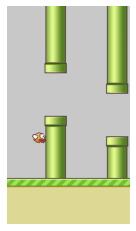

In [250]:
plt.imshow(ndimage.rotate(np.flip(state,0), 270), cmap='gray')
plt.axis('off')
plt.savefig('./imgs/default_view.svg', format='svg')

print('State dimension:', state.size)


Image size: (288, 512, 3)
State dimension: 147456


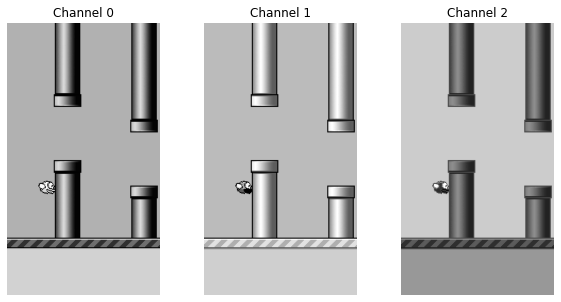

In [252]:
print('Image size:',np.shape(state) )

fig, ax = plt.subplots(1, 3, figsize=(10,5))

ch0 = state[:,:,0]
ax[0].set_title('Channel 0')
ax[0].imshow(ndimage.rotate(np.flip(ch0,0), 270), cmap='gray');
ax[0].axis('off')
ch1 = state[:,:,1]

ax[1].set_title('Channel 1')
ax[1].imshow(ndimage.rotate(np.flip(ch1,0), 270), cmap='gray');
ax[1].axis('off')

ch2 = state[:,:,2]
ax[2].set_title('Channel 2')
ax[2].imshow(ndimage.rotate(np.flip(ch2,0), 270), cmap='gray');
ax[2].axis('off')
plt.savefig('./imgs/channels.svg', format='svg')

print('State dimension:', ch2.size)


#### Reducing size of single image

In [284]:
ch2_red = ch2[70:280,0:400]


Channel 2 cropped
State dimension: 84000


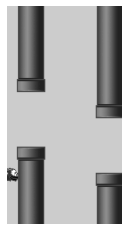

In [285]:
print('\nChannel 2 cropped')
plt.imshow(ndimage.rotate(np.flip(ch2_red,0), 270), cmap='gray');
plt.axis('off')

plt.savefig('./imgs/single_channel_cropped.svg', format='svg')

print('State dimension:', ch2_red.size)

#### Lowering resolution

State dimension: 840


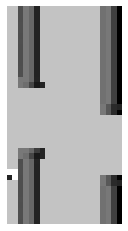

In [286]:
ch2_red_lowres = max_pool(ch2_red, 10)
plt.imshow(ndimage.rotate(np.flip(ch2_red_lowres,0), 270), cmap='gray');
plt.axis('off')
plt.savefig('./imgs/single_channel_cropped_maxpooled10.svg', format='svg')

print('State dimension:', ch2_red_lowres.size)


#### Dynamic resolution

In [287]:
ch2_red_lowres.shape

(21, 40)

In [288]:
from matplotlib.patches import Rectangle

State dimension: 560


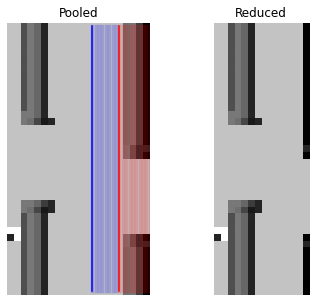

In [290]:
fig, ax = plt.subplots(1, 2, figsize=(6,5))

ax[0].imshow(ndimage.rotate(np.flip(ch2_red_lowres,0), 270),cmap='gray')
ax[0].plot([16, 16], [0, 39], color='red')
k = 16
while(k<21):
    ax[0].plot([k, k], [0, 39], color='red',alpha=0.2, lw = 3.48)
    k = k + .5
    
ax[0].plot([12, 12], [0, 39], color='blue')
k = 12
while(k<16):
    ax[0].plot([k, k], [0, 39], color='blue',alpha=0.2, lw = 3.4)
    k = k + .5

#ax[0].plot([2,2], [0,29], color = 'red')
ax[0].axis('off')
ax[0].set_title('Pooled')
#maxpool_col1 = ch2_red_lowres[:1,:].max(axis=0)
maxpool_col2 = ch2_red_lowres[12:16,:].min(axis=0)
maxpool_col3 = ch2_red_lowres[16:,:].min(axis=0)
ch2_red_lowres_dym = np.vstack((np.vstack((ch2_red_lowres[:12,:], maxpool_col2 )), maxpool_col3)) 
ax[1].imshow(ndimage.rotate(np.flip(ch2_red_lowres_dym,0), 270), cmap='gray')
ax[1].axis('off')
ax[1].set_title('Reduced')

plt.savefig('./imgs/single_channel_cropped_maxpooled10_reduced.svg', format='svg')

print('State dimension:', ch2_red_lowres_dym.size)

---

In [229]:
player2 = Flappy(rgb = True)

In [225]:
player2.training_loop(2500, nn.SmoothL1Loss(), torch.optim.SGD, lr=1e-2)

  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [230]:
# Lets see once how it plays
_, state = player2.play_a_game(debug = False, show = True)

SCORE: 101


---
## Resources:
* [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)